
# 📧 Step 1: Project Setup and Library Imports

First, we'll set up our environment by importing the essential Python libraries for data manipulation (**pandas**), numerical operations (**numpy**), text processing (**re**, **nltk**), and machine learning (**scikit-learn**).

We'll also download the necessary **NLTK** resources like **stopwords** and **wordnet** for text preprocessing.

---


In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK data (if not already downloaded)
# You only need to run these lines once in your environment
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet.zip')
except LookupError:
    nltk.download('wordnet')

print("Libraries imported and NLTK data is ready.")

Libraries imported and NLTK data is ready.



# 📊 Step 2: Load and Explore the Data

Next, we'll load the **"SMS Spam Collection Dataset"** using **pandas**. The dataset usually comes with unnecessary columns, so we'll select only **v1** (the label) and **v2** (the message).

We'll rename them to **label** and **message** for clarity, and then perform a quick exploration to check:

* The first few rows
* Data types
* The distribution between **"ham"** and **"spam"**

---


In [2]:
# Load the dataset from the typical Kaggle input directory
try:
    df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
except FileNotFoundError:
    print("Dataset not found at the Kaggle path. Trying local 'spam.csv'...")
    df = pd.read_csv('spam.csv', encoding='latin-1')

# Data cleaning and preparation
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

# Map labels to numerical values for easier processing
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

print("--- Dataset Head ---")
print(df.head())
print("\n--- Class Distribution ---")
print(df['label'].value_counts())

--- Dataset Head ---
  label                                            message  label_num
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni...          0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1
3   ham  U dun say so early hor... U c already then say...          0
4   ham  Nah I don't think he goes to usf, he lives aro...          0

--- Class Distribution ---
label
ham     4825
spam     747
Name: count, dtype: int64




# 🧹 Step 3: Text Preprocessing

This is a crucial step in any NLP project. We need to clean our text data to make it suitable for a machine learning model.

Our preprocessing pipeline will involve several key tasks:

* **Lowercasing:** Converts all text to lowercase.
* **Removing Punctuation & Numbers:** Eliminates non-alphabetic characters.
* **Tokenization:** Splits sentences into a list of words.
* **Stop Word Removal:** Removes common English words (e.g., *"the"*, *"is"*, *"a"*) that don't add much meaning.
* **Lemmatization:** Reduces words to their root form (e.g., *"running"* becomes *"run"*). This helps the model treat different forms of a word as the same item.

We'll create a function to perform these steps and apply it to our **message** column.


---


In [3]:
# Initialize the lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Keep only alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    
    # Tokenize: split text into words
    words = text.split()
    
    # Lemmatize and remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # Join words back into a single string
    return ' '.join(words)

# Apply the preprocessing function to the message column
df['processed_message'] = df['message'].apply(preprocess_text)

print("--- Preprocessing Example ---")
print("Original message:\n", df['message'][0])
print("\nProcessed message:\n", df['processed_message'][0])

--- Preprocessing Example ---
Original message:
 Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Processed message:
 go jurong point crazy available bugis n great world la e buffet cine got amore wat



# 🔢 Step 4: Feature Engineering with TF-IDF

Machine learning models require numerical input. We'll convert our cleaned text into a numerical format using the **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorizer.

**TF-IDF** is effective because it not only counts word frequency (**TF**) but also down-weights words that are common across all messages (**IDF**), giving more importance to words that are distinctive to a specific class (like *"free," "win," "prize"* for spam).

First, we need to split our data into **training** and **testing** sets. This ensures we can evaluate our model's performance on data it has never seen before. We use **`stratify=y`** to maintain the same percentage of spam and ham messages in both the train and test sets.

---


In [4]:
# Define features (X) and target (y)
X = df['processed_message']
y = df['label_num']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and apply the TF-IDF Vectorizer
# We'll limit it to the top 3000 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_features=3000)

# Fit on training data and transform both train and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("--- Data Splitting and Vectorization ---")
print(f"Shape of training data: {X_train_tfidf.shape}")
print(f"Shape of testing data: {X_test_tfidf.shape}")

--- Data Splitting and Vectorization ---
Shape of training data: (4457, 3000)
Shape of testing data: (1115, 3000)



# 🤖 Step 5: Build and Train the Model

For this text classification task, the **Multinomial Naive Bayes** algorithm is an excellent choice.

It's a **probabilistic model** that is fast, efficient, and works remarkably well with text data like that produced by **TF-IDF**.

We'll initialize the model and train it using our vectorized training data (**X\_train\_tfidf**) and corresponding labels (**y\_train**).

---


In [5]:
# Initialize the Multinomial Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_train_tfidf, y_train)

print("✅ Model training complete.")

✅ Model training complete.



# 📈 Step 6: Evaluate Model Performance

Now that the model is trained, we'll use the **test set** to evaluate its performance. We'll make predictions on **X\_test\_tfidf** and compare them to the actual labels (**y\_test**).

Key metrics include:

* **Accuracy:** The percentage of total correct predictions.
* **Precision:** Of all messages we predicted as spam, how many were actually spam? *(Important for not annoying users with false alarms).*
* **Recall:** Of all the actual spam messages, how many did we catch? *(Important for catching as much spam as possible).*
* **F1-Score:** The harmonic mean of Precision and Recall.
* **Confusion Matrix:** A table that visualizes the model's performance by showing correct and incorrect predictions for each class.

---


--- Classification Report ---
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       0.98      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115


--- Confusion Matrix ---


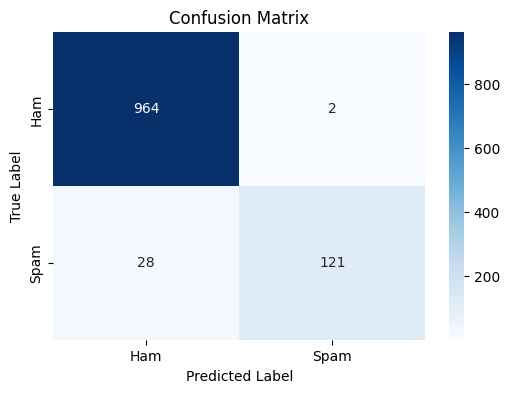

In [6]:
# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Print the detailed classification report
print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# Generate and plot the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# 🧪 Step 7: Test with New Messages

Finally, let's create a simple function to see how our model performs on brand new, unseen messages.

This function will take a raw text message, apply the same **preprocessing** and **TF-IDF transformation** steps, and use our trained model to predict whether it's **"Spam"** or **"Ham"**.

---


In [7]:
def predict_message(message):
    """
    Predicts if a given message is Spam or Ham.
    """
    # Preprocess the message
    processed_msg = preprocess_text(message)
    # Vectorize the message using the trained TF-IDF vectorizer
    tfidf_msg = tfidf_vectorizer.transform([processed_msg])
    # Predict the class
    prediction = model.predict(tfidf_msg)
    
    return "Spam" if prediction[0] == 1 else "Ham"

# Example 1: A likely spam message
test_message_1 = "URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010"
print(f"Message: '{test_message_1}'")
print(f"Prediction: {predict_message(test_message_1)}\n")

# Example 2: A likely ham message
test_message_2 = "Hey, can you send me the project report by 5 PM? Thanks!"
print(f"Message: '{test_message_2}'")
print(f"Prediction: {predict_message(test_message_2)}")

Message: 'URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010'
Prediction: Spam

Message: 'Hey, can you send me the project report by 5 PM? Thanks!'
Prediction: Ham
